In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import io
from PIL import Image
import psycopg2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers as tfl
from tensorflow.keras import regularizers
import random
from tensorflow import keras

2022-10-24 21:45:54.608692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 21:45:54.924154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-24 21:45:54.924177: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-24 21:45:54.968395: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-24 21:45:55.789813: W tensorflow/stream_executor/platform/de

In [38]:
def convert_data(data, file_name):

    with open(file_name, 'wb') as file:
        file.write(data)

In [105]:
conn.close()

In [41]:
conn = psycopg2.connect(
   database="d6l57e709ho9u8", user='pnahkcxihrrzjr', password='29ba5ea5b346d61c14669cbdd5bdad48de6aeed1cf67539a8f05603f57d92d9b', host='ec2-46-51-187-237.eu-west-1.compute.amazonaws.com', port= '5432'
)

In [42]:
cursor = conn.cursor()

In [43]:
cursor.execute('''SELECT * from Pictures''')

In [44]:
records = cursor.fetchall()

In [ ]:
for row in records:
    picture_id = row[0] 
    image = row[1]
    label = row[2]
    if picture_id != 88 and picture_id != 182 and picture_id != 238 and picture_id != 363 and picture_id != 375 and picture_id != 381 and picture_id != 387 and picture_id != 441 and picture_id != 390:
        if picture_id == 21:
            label = 0
        if picture_id == 30:
            label = 0
        if picture_id == 315:
            label = 5
        if picture_id == 451:
            label = 1
        if picture_id == 481:
            label = 2
        if picture_id == 532:
            label = 8
        if picture_id == 679:
            label = 9
        if picture_id == 693:
            label = 1
        img = Image.open(f"/home/serhii/prog/datasets/digits_dataset_labeled/{label}/{picture_id}.jpeg")
        bbox = Image.eval(img, lambda px: 255-px).getbbox()
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        if height > width:
            width = int(20.0 * width / height)
            height = 20
        else:
            height = int(20.0 * width / height)
            width = 20
        hstart = int((28 - height) / 2)
        wstart = int((28 - width) / 2)
        img_temp = img.crop(bbox).resize((width, height), Image.Resampling.BOX)
        new_img = Image.new('L', (28,28), 255)
        new_img.paste(img_temp, (wstart, hstart))
        new_img = Image.eval(new_img, lambda px: 255-px)
        data = np.asarray(new_img)
        data1 = data.copy()
        for x in np.nditer(data1, op_flags = ['readwrite']):
            if x[...] >= 25:
                x[...] = 255
            if x[...] < 25:
                x[...] = 0
        new_img_w = Image.fromarray(data1)
        new_img_w.save(f"/home/serhii/prog/datasets/for_aug/{label}/{picture_id}.jpeg")
    else: print(f'Удалена пустая картинка {picture_id}')

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (28, 28)
directory = "/home/serhii/prog/datasets/for_aug/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode='grayscale',
                                             validation_split=0.2,
                                             label_mode='categorical',
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode='grayscale',
                                             label_mode='categorical',
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 1006 files belonging to 10 classes.
Using 805 files for training.
Found 1006 files belonging to 10 classes.
Using 201 files for validation.


2022-10-20 16:17:32.745551: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-20 16:17:32.745575: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (serhii-ASUS-TUF-Gaming-A15-FA506IU-FA506IU): /proc/driver/nvidia/version does not exist
2022-10-20 16:17:32.747373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def convolutional_model(input_shape):
    
    input_img = tf.keras.Input(shape=input_shape)
    X = tfl.RandomRotation(0.08)(input_img)
    X1 = tfl.RandomZoom(0.1)(X)
    Z1 = tfl.Conv2D(16, 4, activation='linear', padding="same", kernel_regularizer=regularizers.l2(0.01))(X1)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(2, 2), padding='same')(A1)
    Z2 = tfl.Conv2D(32, 4, activation='linear', padding="same", kernel_regularizer=regularizers.l2(0.01))(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=(2, 2), padding='same')(A2)
    F = tfl.Flatten()(P2)
    FC1 = tfl.Dense(1568, activation='ReLU', kernel_regularizer=regularizers.l2(0.01))(F)
    DP1 = tfl.Dropout(0.5)(FC1)
    FC2 = tfl.Dense(625, activation='ReLU', kernel_regularizer=regularizers.l2(0.01))(DP1)
    DP2 = tfl.Dropout(0.5)(FC2)
    outputs = tfl.Dense(10, activation='softmax')(DP2)
    
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model


In [4]:
conv_model = convolutional_model((28, 28, 1))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        272       
                                                                 
 re_lu (ReLU)                (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                           

In [5]:
history = conv_model.fit(train_dataset, epochs=80, validation_data=validation_dataset)

Epoch 1/80
 5/26 [====>.........................] - ETA: 0s - loss: 62.4100 - accuracy: 0.1000

2022-10-20 16:18:13.654552: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24485888 exceeds 10% of free system memory.
2022-10-20 16:18:13.654630: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24485888 exceeds 10% of free system memory.
2022-10-20 16:18:13.664717: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15604736 exceeds 10% of free system memory.
2022-10-20 16:18:13.707261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24485888 exceeds 10% of free system memory.
2022-10-20 16:18:13.707375: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24485888 exceeds 10% of free system memory.


26/26 [==============================] - 4s 47ms/step - loss: 34.7685 - accuracy: 0.2050 - val_loss: 21.6917 - val_accuracy: 0.3930
Epoch 2/80
26/26 [==============================] - 1s 40ms/step - loss: 20.6822 - accuracy: 0.3590 - val_loss: 18.8928 - val_accuracy: 0.6716
Epoch 3/80
26/26 [==============================] - 1s 41ms/step - loss: 18.2435 - accuracy: 0.5689 - val_loss: 17.3168 - val_accuracy: 0.6965
Epoch 4/80
26/26 [==============================] - 1s 43ms/step - loss: 16.6399 - accuracy: 0.6460 - val_loss: 15.6102 - val_accuracy: 0.8010
Epoch 5/80
26/26 [==============================] - 1s 42ms/step - loss: 15.1106 - accuracy: 0.7665 - val_loss: 14.3633 - val_accuracy: 0.8458
Epoch 6/80
26/26 [==============================] - 1s 39ms/step - loss: 13.8282 - accuracy: 0.8211 - val_loss: 13.4047 - val_accuracy: 0.8408
Epoch 7/80
26/26 [==============================] - 1s 39ms/step - loss: 12.8847 - accuracy: 0.8161 - val_loss: 12.5063 - val_accuracy: 0.8408
Epoch 8/80

Epoch 59/80
26/26 [==============================] - 1s 39ms/step - loss: 1.0467 - accuracy: 0.9540 - val_loss: 1.1269 - val_accuracy: 0.9353
Epoch 60/80
26/26 [==============================] - 1s 39ms/step - loss: 0.9887 - accuracy: 0.9652 - val_loss: 1.0609 - val_accuracy: 0.9502
Epoch 61/80
26/26 [==============================] - 1s 39ms/step - loss: 0.9594 - accuracy: 0.9602 - val_loss: 1.0381 - val_accuracy: 0.9502
Epoch 62/80
26/26 [==============================] - 1s 39ms/step - loss: 0.9954 - accuracy: 0.9379 - val_loss: 1.0887 - val_accuracy: 0.9254
Epoch 63/80
26/26 [==============================] - 1s 39ms/step - loss: 1.0335 - accuracy: 0.9342 - val_loss: 1.0968 - val_accuracy: 0.9453
Epoch 64/80
26/26 [==============================] - 1s 40ms/step - loss: 1.0498 - accuracy: 0.9379 - val_loss: 1.2123 - val_accuracy: 0.9055
Epoch 65/80
26/26 [==============================] - 1s 39ms/step - loss: 1.0007 - accuracy: 0.9491 - val_loss: 1.1418 - val_accuracy: 0.9204
Epoch 

/tmp/ipykernel_26716/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_26716/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

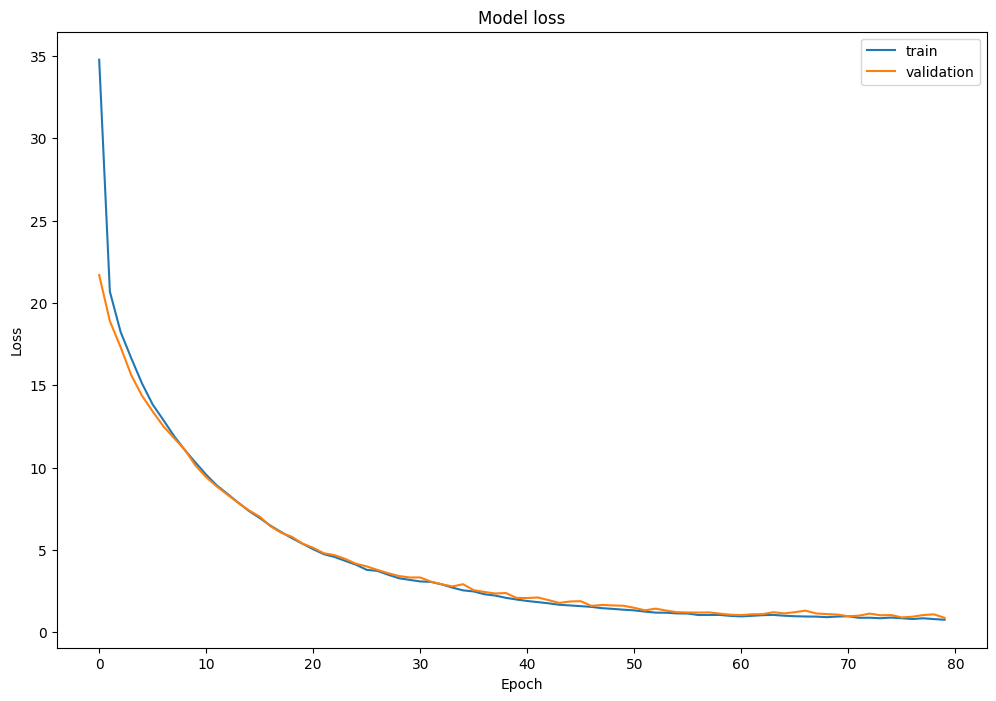

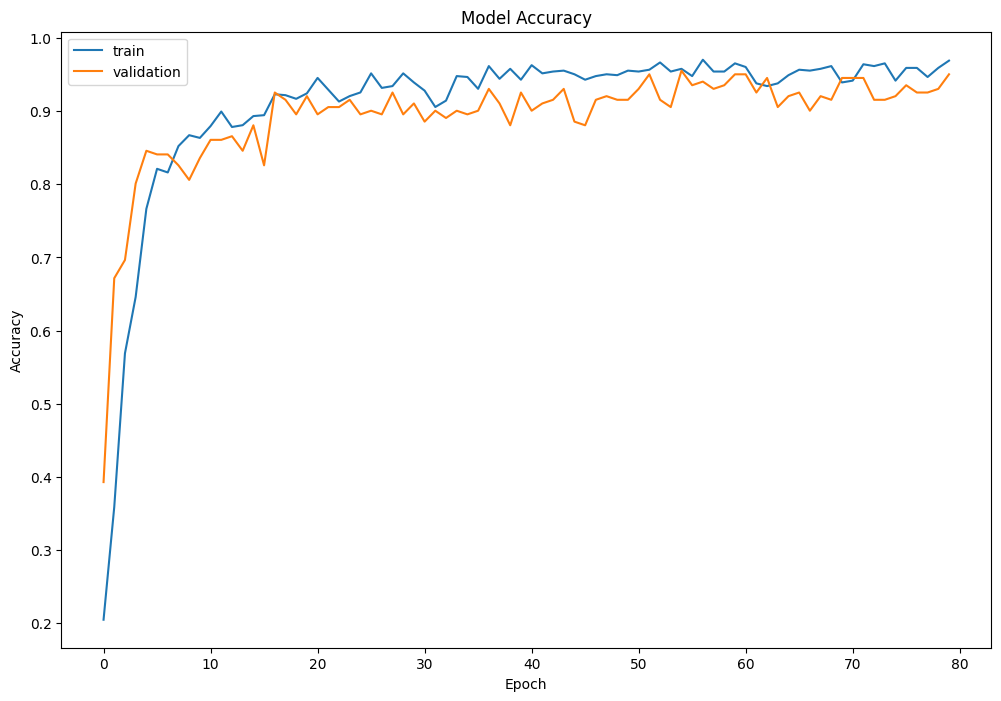

In [6]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [7]:
conv_model.save('first_model_for_deploy.h5')